# ReThink Media MediaCloud API

This notebook will provide a user manual and example use cases for ReThink Media's MediaCloud API functions. The functions in this notebook will provide the capabilities to:

- Search different online news to count stories relevant to a query, over different time periods
- Calculate the percentage of stories within a certain context that contain important keywords
- Create wordclouds for frequent words contained in news stories
- Create plots tracking the attention given to certain topic(s) over a period of time

As an example use case for these functions, this notebook will compare the discussions around the coming out of two transgender celebrities: Caitlin Jenner and Elliot Page.

## Defining Functions

The first part of this notebook is dedicated to defining and explaining the functions mentioned above, with the example use case to follow.

### Authentication and utility functions

These functions are utility functions that are embedded within the main ones, and must be initialized before the others are used. Run the cells below before running the other functions.

**IMPORTANT NOTE:** The MediaCloud API requires an API key in order to access the functionalities used in this notebook. You can either pass your API key into the functions, in the `api_key` argument, or create a text file named `.env` in the home folder of your notebook, containing just the following line of text:

`MC_API_KEY="your_api_key"`

In [1]:
# defining API key, instantiating MediaCloud API
def init_mc_api(api_key=None):
    
    # importing necessary modules
    from dotenv import load_dotenv
    import os
    import mediacloud.api
    
    # loading environment variables from .env file
    load_dotenv()
    
    # if no API key is passed, function assumes API key is defined in .env file as MC_API_KEY
    if not api_key:
        api_key = os.getenv("MC_API_KEY")
    
    # returning API instance
    return mediacloud.api.MediaCloud(api_key)

In [2]:
# formatting date ranges for MediaCloud API calls.
# required arguments: MediaCloud API instance (from init_mc_api) and date range, eg ["8/1/2021", "9/30/2021"]
def clean_api_date(mediacloud_api, date_range, verbose=False):
    
    # importing necessary modules
    from datetime import datetime
    from dateutil import parser
    
    # making sure two dates are passed into the function
    assert len(date_range) == 2, "Please provide both a start and end date for the date interval."
    
    # parsing dates, returning API date range clause
    start_date = parser.parse(date_range[0])
    end_date = parser.parse(date_range[1])
    if verbose:
        print(f"Date range: between {start_date.strftime('%m/%d/%Y')} and {end_date.strftime('%m/%d/%Y')}")
    return mediacloud_api.dates_as_query_clause(start_date, end_date)

### Story count for multiple sources

This function counts the number of stories that contain a query that is passed into the function. Pass a query and a dictionary of source names and MediaCloud media ID's into the function, and it will return a pandas DataFrame with each source's relevant stories, total stories, and attention to the passed query, measured by percent coverage. You can also pass a range of dates into the function to make your search more specific. If you would like to see some of the stories from each source, there is also an option to add the URLs to a sample of the relevant stories from each source.

The arguments for the function are:
- `query`: The query that you would like to find relevant stories for
- `sources`: A dict of news sources to search, formatted as {`source name`: `MediaCloud ID`}
- `date_range`: \[`start_date`, `end_date`] for the query
- `query_context`: The overall context that you would like to search within. `query_context=None` will set the context to all of the source's stories within `date_range`, or you can pass a query to calculate attention within a more specific context.
- `api_key`: MediaCloud API key. `api_key=None` assumes that the API key is defined in a `.env` file as `MC_API_KEY`.
- `verbose`: Whether or not to print information as the function runs.
- `urls`: If `True`, the function will add a column to the DataFrame with 20 sample stories from each source relevant to the query.

In [3]:
# building a function to search a string among the sources given
def search_sources(query, sources, date_range=None, query_context=None, api_key=None, verbose=False, urls=False):
    
    # initializing MediaCloud API and cleaning date_range
    mc = init_mc_api(api_key=api_key)
    api_date_range = clean_api_date(mc, date_range) if date_range else None
    
    # ensuring the query is a string
    query = str(query)
    print(f"Query: {query}")
    
    # ensuring sources are given in a dict
    assert type(sources) == dict, "Please provide the sources in a dict, in the format <Source Name>: <MediaCloud ID>"
    
    # initializing dataframe to store the query data
    import pandas as pd
    import numpy as np
    if urls:
        story_counts = pd.DataFrame(columns=["Name", "Relevant Stories", "Total Stories", "Attention (%)", "Story URLs"])
    else:
        story_counts = pd.DataFrame(columns=["Name", "Relevant Stories", "Total Stories", "Attention (%)"])
    story_counts.index.name = "MediaCloud ID"
    
    # going through each source and querying relevant and total stories
    for source_name in sources:
        if verbose:
            print(f"{source_name}:")
        
        # defining overall context and specific query for stories
        if query_context:
            total_query = f'{query_context} and media_id:{sources[source_name]}'
        else:
            total_query = f'media_id:{sources[source_name]}'
        api_query = f'{query} and {total_query}'

        # API calls to count relevant and total stories
        relevant_stories = mc.storyCount(api_query, api_date_range)['count']
        total_stories = mc.storyCount(total_query, api_date_range)['count']
        
        # getting urls for a sample of 20 stories relevant to the query
        if urls:
            stories = mc.storyList(api_query, api_date_range, sort=mc.SORT_RANDOM)
            story_urls = [story['url'] for story in stories]
        
        # appending data to dataframe
        try:
            attention = (relevant_stories / total_stories) * 100
        except ZeroDivisionError:
            attention = np.nan
        if urls:
            story_counts.loc[sources[source_name]] = [source_name, relevant_stories, total_stories, attention, story_urls]
        else:
            story_counts.loc[sources[source_name]] = [source_name, relevant_stories, total_stories, attention]
        
        # printing story count and attention
        if verbose:
            print(f"{relevant_stories} stories about {query}, {total_stories} total")
            if not np.isnan(attention):
                print(f"{attention}% of stories are about {query}\n")
            else:
                print("")
    
    return story_counts

### Percentage of stories that mention keywords

This function calculates the percentage of stories in the sources given that mention keywords and phrases of interest. The arguments for this function are:
- `keywords`: A list of keywords or phrases to search for.
- `sources`: A dict of news sources to search, formatted as {`source name`: `MediaCloud ID`}
- `date_range`: \[`start_date`, `end_date`] for the query
- `query_context`: The overall context that you would like to search within. `query_context=None` will set the context to all of the source's stories within `date_range`, or you can pass a query to calculate attention within a more specific context.
- `api_key`: MediaCloud API key. `api_key=None` assumes that the API key is defined in a `.env` file as `MC_API_KEY`.

The function prints the percentage of stories containing each keyword, as well as the percentage of stories that mention any of the keywords, and returns an array of the percentages mentioned.

In [4]:
# calculating number of 9/11 stories that mention some topics and keywords we're interested in
def calculate_percentages(keywords, sources, date_range=None, query_context=None, api_key=None):
    
    # initializing MediaCloud API and cleaning date_range
    mc = init_mc_api(api_key=api_key)
    api_date_range = clean_api_date(mc, date_range) if date_range else None
    
    # formatting media_ids for API query
    media_ids = list(sources.values())
    api_media_ids = " OR ".join(f"media_id:{media_id}" for media_id in media_ids)

    # defining overall context and specific query for stories
    if query_context:
        total_query = f'{query_context} and ({api_media_ids})'
    else:
        total_query = f'({api_media_ids})'
    
    # joining keywords to calculate aggregate percentages
    all_keywords = " OR ".join(keywords)

    # adding queries to list to loop through later
    keyword_queries = [f'{keyword} and {total_query}' for keyword in keywords+[f"({all_keywords})"]]
    
    # story count for query context
    total_results = mc.storyCount(total_query, api_date_range)['count']

    # keyword story counts
    keyword_results = [mc.storyCount(keyword_query, api_date_range)['count'] for keyword_query in keyword_queries]
    
    # calculating percentages of 9/11 stories that mentioned endless war, profiling, and afghanistan
    import numpy as np
    keyword_percentages = np.divide(keyword_results, total_results) * 100
    keyword_percentages = np.around(keyword_percentages, decimals=2)
    
    # printing percentages
    print("Percentage of stories within specified context that mention:\n")
    for i in range(len(keywords)):
        print(f"{keywords[i]}: {keyword_percentages[i]}%\n")
    print(f"All Keywords: {keyword_percentages[-1]}%")
    
    return keyword_percentages

### Wordclouds

This function takes a query and produces a wordcloud, a visualization of the most popular words within stories relevant to the query. The arguments for this function are:

- `query`: The query that you would like to create a wordcloud for
- `sources`: A dict of news sources to search, formatted as {`source name`: `MediaCloud ID`}
- `date_range`: \[`start_date`, `end_date`] for the query
- `save_img`: Boolean, whether or not to save the wordcloud image as a file
- `filename`: The filename to save the wordcloud image under. The default is "wordcloud.png"
- `custom_stopwords`: Any custom stopwords to remove from the wordcloud image. The `query` is added to the wordclouds by default
- `api_key`: MediaCloud API key. `api_key=None` assumes that the API key is defined in a `.env` file as `MC_API_KEY`
- `verbose`: Boolean, whether or not to print extra information while the function is running

In [47]:
# adapting simple_word_cloud() function from Laura's previous code
def word_cloud(query, sources, date_range, save_img=False, filename="wordcloud.png",
               custom_stopwords=None, api_key=None, verbose=False):
    
    # initializing MediaCloud API and cleaning date_range
    mc = init_mc_api(api_key=api_key)
    api_date_range = clean_api_date(mc, date_range) if date_range else None
    
    # formatting query, sources, and date_range for API
    assert type(query) == str, "Please input a string as the query."
    media_ids = list(sources.values())
    api_media_ids = " OR ".join([f"media_id:{media_id}" for media_id in media_ids])
    
    api_query = f"{query} and ({api_media_ids})"
    if verbose:
        print(f"Query: {api_query}")

    # building term/document matrix, separating word list from word matrix
    story_count = mc.storyCount(api_query, api_date_range)["count"]
    doc_term_matrix = mc.storyWordMatrix(api_query, api_date_range, rows=story_count, max_words=100)
    word_list = doc_term_matrix["word_list"]
    word_matrix = doc_term_matrix["word_matrix"]
    top_words = [word[1] for word in word_list]
    
    # aggregating word frequencies in each document
    word_freqs = {}
    for word_id in range(len(top_words)):
        word_freqs[word_id] = 0
        for story in word_matrix:
            if str(word_id) in word_matrix[story]:
                word_freqs[word_id] += word_matrix[story][str(word_id)]
            else:
                continue
        word_freqs[top_words[word_id]] = word_freqs.pop(word_id)
    
    # importing wordcloud modules
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    import re
    
    # adding query and custom stopwords to set
    stopwords = set(STOPWORDS)
    pattern = re.compile('[\W_]+')
    query_stops = pattern.sub(' ', query)
    print(query_stops)
    print(set(query_stops.split()))
    stopwords = stopwords.union(set(query_stops.split()))
    if custom_stopwords:
        stopwords = stopwords.union(custom_stopwords)
    print(stopwords)
    
    # creating wordcloud image
    wc_fig = plt.figure()
    word_cloud = WordCloud(background_color="white", width=3000, height=2000, 
                           max_words=75, prefer_horizontal=1.0, stopwords=stopwords)
    word_cloud.generate_from_frequencies(word_freqs)
    print(word_cloud.words_)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    if save_img:
        word_cloud.to_file(filename)
        
    return wc_fig

### Attention over time plots:

This function tracks media attention of a given query over time. Pass queries, MediaCloud media ID's of sources, and the date range that you would like to plot into the function, and the output will be one plot, with each query's attention over time plotted against each other. You can adjust the figure size as an argument for the function as well. The arguments of this function are:

- `query`: The query that you would like to create a wordcloud for
- `sources`: A dict of news sources to search, formatted as {`source name`: `MediaCloud ID`}
- `date_range`: \[`start_date`, `end_date`] for the query
- `query_context`: The overall context that you would like to search within. `query_context=None` will set the context to all of the source's stories within `date_range`, or you can pass a query to calculate attention within a more specific context.
- `api_key`: MediaCloud API key. `api_key=None` assumes that the API key is defined in a `.env` file as `MC_API_KEY`
- `save_img`: Boolean, whether or not to save the plot image as a file
- `filename`: The filename to save the plot image under. The default is "attention_plot.png"
- `fig_size`: A tuple of the figure size. The default is `(10,5)`
- `verbose`: Boolean, whether or not to print extra information while the function is running

In [51]:
# function to plot attention over time for one or more queries
def attention_plots(queries, sources, date_range, query_context=None, api_key=None, 
                    save_img=False, filename="attention_plot.png", fig_size=(10,5), verbose=False):
    
    # initializing MediaCloud API and cleaning date_range
    mc = init_mc_api(api_key=api_key)
    api_date_range = clean_api_date(mc, date_range) if date_range else None
    
    # formatting query for plots
    if type(queries) == str:
        queries = [queries]
    else:
        assert type(queries)==list, "Please pass either a list or string of queries into this function."
        
    # formatting media_ids for API query
    media_ids = list(sources.values())
    api_media_ids = " OR ".join(f"media_id:{media_id}" for media_id in media_ids)
    
    # looping over each query and adding attention vs time plot to figure
    import matplotlib.pyplot as plt
    figure = plt.figure(figsize=fig_size)
    i = 1
    for query in queries:
        if verbose:
            print(f"Query {i}: {query}")
        
        # defining overall context and specific queries
        if query_context:
            total_query = f"{query_context} and ({api_media_ids})"
        else:
            total_query = f"({api_media_ids})"
        relevant_query = f"{query} and {total_query}"
        
        # making API calls for relevant and total story counts (by day)
        relevant_results = mc.storyCount(relevant_query, api_date_range, split=True, split_period='day')['counts']
        if not relevant_results:
            print(f"0 results for {query} between {start_date.strftime('%m/%d/%Y')} and {end_date.strftime('%m/%d/%Y')}.")
            continue
        total_results = mc.storyCount(total_query, api_date_range, split=True, split_period='day')['counts']
        
        # creating dataframes for query and total results
        import pandas as pd
        relevant_df = pd.DataFrame(relevant_results)
        relevant_df["date"] = pd.to_datetime(relevant_df["date"])
        total_df = pd.DataFrame(total_results)
        total_df["date"] = pd.to_datetime(total_df["date"])
        
        # joining dataframes on date, filling missing dates from query with zeros
        join_df = total_df.merge(relevant_df, how="outer", on="date", suffixes=("_total", "_relevant"))
        join_df["count_relevant"] = join_df["count_relevant"].fillna(0).astype(int)
        join_df = join_df[["date", "count_total", "count_relevant"]]
        
        # calculating attention
        join_df["attention"] = (join_df["count_relevant"] / join_df["count_total"]) * 100
        
        # plotting attention over time
        label = f"Query {i}"
        plt.plot(join_df["date"], join_df["attention"], '-', label=label)
        
        i += 1
    
    # setting parameters for plot
    plt.suptitle("Attention over time")
    plt.legend(loc=0)
    plt.xlabel("Date")
    plt.ylabel("Attention in sources (%)")
    plt.xticks(rotation=60)
    plt.show()
    
    # saving image
    if save_img:
        figure.savefig(filename, bbox_inches="tight", facecolor="w")
        
    return figure

## Example Use Case: Caitlin Jenner and Elliot Page

The rest of the notebook will walk through an example use case for these functions: comparing the discussions around Caitlin Jenner and Elliot Page when they came out as transgender. The example will use all of the functions defined above as a simple baseline for users to see how they work and what their outputs are.

In [7]:
# importing a module so we can time how long the functions take to run
import time

# defining the dictionary of sources to search for the example use cases
example_sources = {
    "Associated Press": 1154,
    "NPR": 1096,
    "Politico": 18268,
    "Vice": 26164,
    "Buzzfeed": 6218,
    "Chicago Tribune": 9,
    "CNN Wire": 1095,
    "Fox News": 1092,
    "Houston Chronicle": 10,
    "HuffPost": 27502,
    "LA Times": 6,
    "Newsweek": 56510,
    "Reuters News": 4442,
    "Talking Points Memo": 113,
    "The Boston Globe": 15,
    "Christian Science Monitor": 3,
    "The Daily Beast": 1707,
    "The Hill": 18364,
    "The Intercept": 269138,
    "The Miami Herald": 28,
    "New York Times": 1,
    "The Wall Street Journal": 1150,
    "The Washington Post": 2,
    "The Washington Times": 101,
    "USA Today": 4,
    "Vox": 104828,
}

### Story count

We can get an idea of the media attention given to these two celebrities by calculating the percentage of stories they were mentioned in around the time they came out. We can use the `search_sources()` function to accomplish this. We can set the `date_range` parameter to cover the period around each celebrity's public coming out. To expand our search, we can also add the Elliot and Caitlin's previous names to the query, in case the news outlets refer to them by either name when they came out.

In [68]:
# defining query parameters for Elliot Page
page_query = '(elliot OR ellen) AND page'
page_dates = ["11/21/2020", "12/07/2020"]

# running and timing search_sources()
start_time = time.time()
page_counts = search_sources(page_query, example_sources, date_range=page_dates)
end_time = time.time()
print(f"Time: {round((end_time-start_time)/60, 2)} min")

# displaying the top 5 sources, sorted by attention
page_counts.sort_values(by="Attention (%)", ascending=False).head()

Query: (elliot OR ellen) AND page
Time: 0.47 min


,Name,Relevant Stories,Total Stories,Attention (%)
MediaCloud ID,,,,
27502,HuffPost,5,992,0.504032
15,The Boston Globe,3,853,0.351700
6218,Buzzfeed,5,1632,0.306373
6,LA Times,3,1174,0.255537
1,New York Times,7,2841,0.246392


In [69]:
# defining query parameters for Caitlin Jenner
jenn_query = '(caitlin OR bruce) AND jenner'
jenn_dates = ["04/15/2015", "05/01/2015"]

# running and timing search_sources()
start_time = time.time()
jenn_counts = search_sources(jenn_query, example_sources, date_range=jenn_dates)
end_time = time.time()
print(f"Time: {round((end_time-start_time)/60, 2)} min")

# displaying the top 5 sources, sorted by attention
jenn_counts.sort_values(by="Attention (%)", ascending=False).head()

Query: (caitlin OR bruce) AND jenner
Time: 0.46 min


,Name,Relevant Stories,Total Stories,Attention (%)
MediaCloud ID,,,,
1707,The Daily Beast,5,342,1.461988
113,Talking Points Memo,1,90,1.111111
1095,CNN Wire,16,1651,0.969110
56510,Newsweek,3,355,0.845070
104828,Vox,2,331,0.604230


It seems like the numbers are still pretty low for both queries, so let's define a more specific context to conduct our search within. We can define a `query_context` in order to search the sources for mentions of Elliot and Caitlin, within the context of stories about transgender individuals.

In [70]:
# running and timing search_sources()
start_time = time.time()
page_counts = search_sources(page_query, example_sources, date_range=page_dates, query_context="transgender")
end_time = time.time()
print(f"Time: {round((end_time-start_time)/60, 2)} min")

# displaying the top 5 sources, sorted by attention
page_counts.sort_values(by="Relevant Stories", ascending=False).head()

Query: (elliot OR ellen) AND page
Time: 0.46 min


,Name,Relevant Stories,Total Stories,Attention (%)
MediaCloud ID,,,,
56510,Newsweek,4,15,26.666667
4,USA Today,4,13,30.769231
1,New York Times,4,18,22.222222
2,The Washington Post,3,22,13.636364
1095,CNN Wire,3,13,23.076923


In [71]:
# running and timing search_sources()
start_time = time.time()
jenn_counts = search_sources(jenn_query, example_sources, date_range=jenn_dates, query_context="transgender")
end_time = time.time()
print(f"Time: {round((end_time-start_time)/60, 2)} min")

# displaying the top 5 sources, sorted by attention
jenn_counts.sort_values(by="Relevant Stories", ascending=False).head()

Query: (caitlin OR bruce) AND jenner
Time: 0.48 min


,Name,Relevant Stories,Total Stories,Attention (%)
MediaCloud ID,,,,
27502,HuffPost,21,89,23.595506
2,The Washington Post,14,24,58.333333
1095,CNN Wire,13,17,76.470588
4,USA Today,7,16,43.750000
1707,The Daily Beast,4,6,66.666667


This query is more useful than the previous ones: we can see that Caitlin Jenner basically dominated the media attention around transgender people when she came out, but Elliot Page took up less of the transgender coverage when he came out.

### Deadnames and misgendering

We can also check how many times the celebrities were mentioned by their previous (or "dead") names when they came out, as well as how many times they were misgendered, or referenced by the incorrect pronouns. We can use the `calculate_percentages()` function to accomplish this.

In [77]:
# checking how many times Elliot Page was referenced by his previous name
keywords = ["ellen", "she", "her", "hers"]

percentages = calculate_percentages(keywords, example_sources, date_range=page_dates, query_context=page_query)

Percentage of stories within specified context that mention:

ellen: 41.38%

she: 41.38%

her: 39.66%

hers: 1.72%

All Keywords: 65.52%


In [78]:
# checking how many times Caitlin Jenner was referenced by her previous name
keywords = ["bruce", "he", "him", "his"]

percentages = calculate_percentages(keywords, example_sources, date_range=jenn_dates, query_context=jenn_query)

Percentage of stories within specified context that mention:

bruce: 99.35%

he: 70.78%

him: 47.4%

his: 70.13%

All Keywords: 100.0%


We can see that Caitlin Jenner was referenced by her previous name in almost every news story about her when she came out, but Elliot Page was only referenced by his previous name in less than half of the stories. Given the five year gap between the two celebrities coming out, this could signal that a shift had taken place in how the media talks about transgender people after they have come out.

### Wordclouds

We can get a better idea about how these celebrities are covered by looking at the word clouds generated from stories that mention them when they came out. We can use the `word_cloud()` function for this.

 elliot OR ellen AND page
{'ellen', 'AND', 'OR', 'elliot', 'page'}
{'could', 'in', 'of', 'otherwise', 'does', "i'm", 'be', 'too', "she'd", 'so', 'some', 'into', 'and', 'herself', "she'll", 'cannot', 'been', "we've", 'after', 'whom', 'ourselves', "we'll", "there's", 'himself', 'k', 'your', 'he', 'few', 'same', 'just', 'this', 'where', 'ours', 'themselves', "we're", "here's", 'also', 'ought', 'these', 'on', 'ellen', 'my', 'other', "weren't", 'than', 'more', 'any', 'his', 'those', 'OR', 'was', 'page', 'out', 'under', 'how', 'such', 'since', "shouldn't", 'however', 'yourselves', 'her', "it's", "i'd", 'elliot', "he's", 'further', "haven't", "won't", 'shall', 'with', 'you', "wouldn't", 'has', "wasn't", 'up', 'their', 'because', 'down', 'nor', "when's", 'for', "they're", "where's", 'com', 'that', 'there', "couldn't", 'which', 'only', "let's", "isn't", 'above', 'it', "they'd", 'our', "they'll", 'itself', 'when', 'below', 'i', 'what', 'not', 'here', 'did', 'its', 'is', "why's", 'no', 'all', "ha

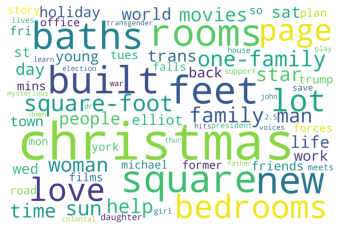

Time to run: 0.18 min


In [74]:
# building wordcloud for Elliot Page
start_time = time.time()
page_cloud = word_cloud(page_query, example_sources, date_range=page_dates)
end_time = time.time()

print(f"Time to run: {round((end_time - start_time)/60, 2)} min")

 caitlin OR bruce AND jenner
{'caitlin', 'bruce', 'AND', 'OR', 'jenner'}
{'could', 'in', 'of', 'otherwise', 'does', "i'm", 'be', 'too', "she'd", 'so', 'some', 'into', 'and', 'herself', "she'll", 'cannot', 'been', "we've", 'after', 'whom', 'ourselves', "we'll", "there's", 'himself', 'k', 'your', 'he', 'few', 'same', 'just', 'this', 'where', 'ours', 'themselves', "we're", "here's", 'also', 'ought', 'these', 'on', 'my', 'other', "weren't", 'than', 'more', 'any', 'his', 'those', 'OR', 'was', 'out', 'under', 'how', 'such', 'since', "shouldn't", 'however', 'yourselves', 'her', "it's", "i'd", "he's", 'further', "haven't", "won't", 'jenner', 'shall', 'with', 'you', "wouldn't", 'has', "wasn't", 'up', 'their', 'because', 'down', 'nor', "when's", 'for', "they're", "where's", 'com', 'that', 'there', "couldn't", 'bruce', 'which', 'only', "let's", "isn't", 'above', 'it', "they'd", 'our', "they'll", 'itself', 'when', 'below', 'i', 'what', 'not', 'here', 'did', 'its', 'is', "why's", 'no', 'all', "hasn

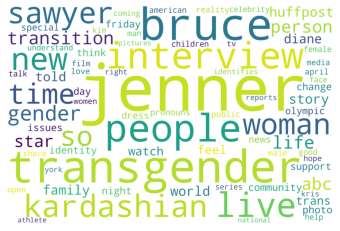

Time to run: 0.14 min


In [75]:
# building wordcloud for Caitlin Jenner
start_time = time.time()
page_cloud = word_cloud(jenn_query, example_sources, date_range=jenn_dates)
end_time = time.time()

print(f"Time to run: {round((end_time - start_time)/60, 2)} min")

### Attention over time
We can track the media attention on Elliot and Caitlin over the past year, to see how much they've been in the public eye since coming out.

Query 1: (elliot OR ellen) AND page
Query 2: (caitlin OR bruce) AND jenner


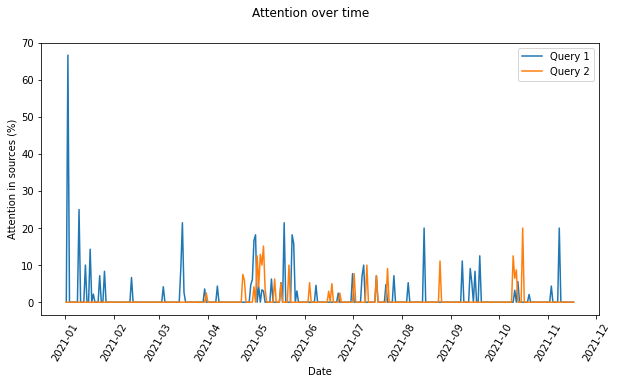

Time to run: 0.06 min


In [76]:
# adding both queries to a list for the function to parse
queries = [page_query, jenn_query]

# defining date range
date_range = ["1/1/2021", "11/17/2021"]

# running and timing function
start_time = time.time()
attention_plot = attention_plots(queries, example_sources, date_range=date_range,
                                 query_context="transgender", verbose=True)
end_time = time.time()
print(f"Time to run: {round((end_time-start_time)/60, 2)} min")